## Import

In [1]:
from qibullet import SimulationManager
from qibullet import NaoVirtual , NaoFsr
import matplotlib.pyplot as plt
import numpy as np
import time
import threading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pickle
import random
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

pybullet build time: May  2 2023 05:58:25


In [2]:
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
print(device, " in use")

cpu  in use


## Nao Bullet

In [3]:
# Launch Simulation Environment
vis = True
simulation_manager = SimulationManager()
nao_sim = simulation_manager.launchSimulation(gui=vis, auto_step=True)
#nao_sim_vis = simulation_manager.launchSimulation(gui=False, auto_step=True)
simulation_manager.setGravity(nao_sim, [0.0, 0.0, -9.81])
nao = None

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=VMware, Inc.
GL_RENDERER=llvmpipe (LLVM 10.0.0, 256 bits)
GL_VERSION=3.3 (Core Profile) Mesa 20.0.8
GL_SHADING_LANGUAGE_VERSION=3.30
pthread_getconcurrency()=0
Version = 3.3 (Core Profile) Mesa 20.0.8
Vendor = VMware, Inc.
Renderer = llvmpipe (LLVM 10.0.0, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


ven = VMware, Inc.
ven = VMware, Inc.


In [4]:
# Joints to monitor
legJoints = [ "LHipRoll", "LHipPitch", "LKneePitch", "LAnklePitch", 
              "RHipRoll", "RHipPitch", "RKneePitch", "RAnklePitch", ]

min_values = np.array( [-0.379472, -1.535889 , -0.092346,	-1.189516  ,
                         -0.790477,	-1.535889,	-0.103083, -1.186448 ] )
max_values = np.array( [ 0.790477, 0.484090, 2.112528, 0.922747, 
                         0.379472, 0.484090,  2.120198, 0.932056 ] )


#min_values = np.array( [-0.379472, -1.535889 , -0.092346,	-1.189516 , -0.397880 ,
#                        -0.790477, 	-1.535889,	-0.103083, -1.186448 , -0.768992] )
#max_values = np.array( [ 0.790477, 0.484090, 2.112528, 0.922747, 0.769001,
#                         0.379472    , 0.484090,  2.120198, 0.932056, 0.397935] )


bucket_width = [ 0.05, 0.1, 0.2,  0.05,
                 0.05, 0.1, 0.2, 0.05  ]

nao_prev_position_X = 0
nao_prev_position_Y = 0

fallen = False

prev_weight_cntr = 0
def env_Reward():
    global prev_weight_cntr,fallen
    x, y, z = nao.getPosition()
    terminated = False
    delX = 5*(x - nao_prev_position_X  )
    delY = 5*(y - nao_prev_position_Y  )
    weight = -(nao.getTotalFsrValues(NaoFsr.LFOOT) + nao.getTotalFsrValues(NaoFsr.RFOOT) )

    # if robot fallen down
    if weight == 0: 
        prev_weight_cntr += 1
    else:
        prev_weight_cntr = 0

    if fallen and prev_weight_cntr > 10:
        reward = -5
        terminated = True
        prev_weight_cntr = 0
        #print("Fallen")
    elif  prev_weight_cntr > 50:
        reward = -5
        terminated = True
        prev_weight_cntr = 0
        #print("Weight")
    else:
        reward = 10*delX + 2
        terminated = False
    
    return reward, terminated


def env_state():
    return nao.getAnglesPosition(legJoints)
    
def env_action(angles, speed):
    nao.setAngles(legJoints, angles ,speed)

def env_itrm_step(itr):
    for _ in range(itr):
        simulation_manager.stepSimulation(nao_sim)

def env_reset():
    global nao_prev_position_X , nao_prev_position_Y, fallen
    global nao
    simulation_manager.resetSimulation(nao_sim)
    simulation_manager.setGravity(nao_sim, [0.0, 0.0, -9.81])
    nao = simulation_manager.spawnNao( 
    nao_sim,
    translation=[0, 0, 0],quaternion=[0, 0, 0, 1],
    spawn_ground_plane=True)
    env_itrm_step(100)
    time.sleep(2)
    nao_prev_position_X, nao_prev_position_Y, _ = nao.getPosition()
    fallen = False
    t1 = threading.Thread(target= nao_fall_detect)
    t1.start()

def env_stop():
    simulation_manager.stopSimulation(nao_sim)
    # wait for limited iterations 

total_steps = 0
max_itr = 10000
def env_step(angles):
    global total_steps, max_itr
    total_steps += 1
    env_action(angles, 0.5)
    #env_itrm_step(50)
    time.sleep(0.2)
    reward, terminated = env_Reward()
    if total_steps > max_itr :
        reward = -100
        truncated = True
    truncated = False
    next_state = env_state()
    return next_state, reward, terminated , truncated

def nao_fall_detect():
    global fallen, nao
    nao.subscribeImu(frequency=100)
    
    while True:
        acc = nao.getImuAccelerometerValues()
        gyr = nao.getImuGyroscopeValues()
        gyr = list(gyr)
        acc = list(acc)
        if gyr[1] < -3 or acc[2]<-5:
            fallen = True
        time.sleep(0.1)
        if fallen:
            break


env_reset()


In [13]:
env_stop()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


## Agent

In [5]:
## Agent 
class walk_Agent:
  def __init__(self, observation_space, action_space , epsilon, epsilon_decay):
    self.observation_space = observation_space
    self.action_space = action_space
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_array = list()
    self.epsilon_min = 0.35

  def step(self, obs, policy, Q):
    self.epsilon = max ( self.epsilon * self.epsilon_decay , self.epsilon_min)
    self.epsilon_array.append(self.epsilon)

    if policy == "e-greedy":

      if np.random.uniform() > self.epsilon:
    
        next_obs = []
        act = []
        for i in range(self.observation_space):
          idx = np.argmax( [ Q[3*i] , Q[3*i + 1], Q[3*i + 2] ])
          if idx == 0:
            next_obs.append( obs[i] + bucket_width[i])
            act.append(0)

          elif idx == 1:
            next_obs.append( obs[i] )
            act.append(1)

          elif idx == 2:
            next_obs.append( obs[i] - bucket_width[i])
            act.append(2)
          
      else:

        act = []
        next_obs = []
        for i,  elem in enumerate(obs) :

          rnd_act = random.choice([ 0.1, 0, -0.1])
          
          if rnd_act == 0.1:
            next_obs.append(elem + bucket_width[i])
            act.append(0)
          
          elif rnd_act == 0:
            next_obs.append(elem)
            act.append(1)
          
          else:
            next_obs.append(elem - bucket_width[i])
            act.append(2)
      
        
      return next_obs , act

    elif policy == "random":
      return np.random.choice(self.action_space.n)

    elif policy == "optimal":
      return np.argmax(Q)
  
  def give_epsilon_history(self):
    return self.epsilon_array

## DQN

In [6]:
### Paramters
epsilon = 1
gamma = 0.9
epsilon_decay = 0.9999

observation_space = 8
action_space= 16

## Environment Initialisation
agent = walk_Agent(observation_space, action_space, epsilon, epsilon_decay)

env_reset()
terminated = False


# Define Action Value model
class DQN_AV(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(observation_space, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3*observation_space)
        )

    def forward(self, x):
        out = self.network_arch(x)
        return out

AV = DQN_AV().to(device)
#print(model)


# Define Target Action model
class DQN_TA(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(observation_space, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3*observation_space)
        )

    def forward(self, x):
        out = self.network_arch(x)
        return out

TA = DQN_TA().to(device)
#print(model)

TA.load_state_dict(AV.state_dict())

# BEGIN_YOUR_CODE
observation = env_state()
observation = np.array([observation], dtype='float32')

input = torch.from_numpy(observation)
print("Observation : " , observation)

out = AV(input)
print("Q Values from Action Value : ", out.detach().numpy())

out = TA(input)
print("Q Values from Target Action : ", out.detach().numpy())

Observation :  [[ 0.11868434  0.12745781 -0.09229428  0.08735427 -0.11897618  0.12781364
  -0.09231556  0.08691113]]
Q Values from Action Value :  [[-0.01990263 -0.0321039   0.03056462  0.06915461  0.0548202   0.02683911
   0.00794177 -0.06615549 -0.03589408 -0.07214473 -0.04553242  0.01414703
  -0.08869927  0.10940303  0.06535514 -0.00701068  0.02077129  0.01893893
  -0.07349551 -0.07539744  0.05524734  0.03329943 -0.02906109 -0.06326863]]
Q Values from Target Action :  [[-0.01990263 -0.0321039   0.03056462  0.06915461  0.0548202   0.02683911
   0.00794177 -0.06615549 -0.03589408 -0.07214473 -0.04553242  0.01414703
  -0.08869927  0.10940303  0.06535514 -0.00701068  0.02077129  0.01893893
  -0.07349551 -0.07539744  0.05524734  0.03329943 -0.02906109 -0.06326863]]


## Train

KeyboardInterrupt: 

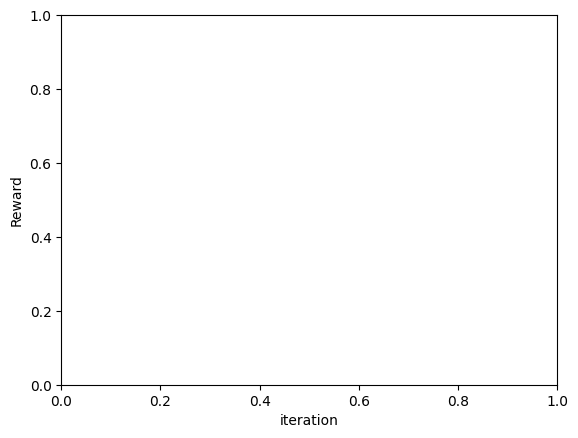

In [7]:
### Paramters
epsilon = 1
gamma = 0.9
epsilon_decay = 0.999

observation_space = 8
action_space= 16

policy = "e-greedy"

D = list()
avg_reward = 0
Cum_reward_arr = list()
no_of_timestep = list()

## Environment Initialisation
agent = walk_Agent(observation_space, action_space, epsilon, epsilon_decay)

## Reset
env_reset()
obs = env_state()
obs = np.array([obs], dtype='float32')
terminated = False

## Parameters
miniBatch = 4
C = 2
episodes = 10
M = 100
learning_rate = 0.0001

optimizer = optim.AdamW(AV.parameters(), lr= learning_rate, amsgrad=True)

fig, ax = plt.subplots()
ax.set_xlabel("iteration")
ax.set_ylabel("Reward")

for m in range(M):
  
  D = list()
  for episode in range(episodes):

    itr = 0
    total_reward = 0

    with torch.no_grad():
      
      # Collect experiences
      while not terminated:

        itr = itr +1
        
        #obs = env_Q_state()
        #obs = np.array([obs], dtype='float32')
        #obs = torch.from_numpy(obs)
        
        obs = env_state() #np.array(obs)
        #obs = list( obs.flatten())
        obs = np.array(obs, dtype='float32')
        obs = obs.flatten()
        Q = AV(torch.tensor(obs, dtype=torch.float)) # 1d array of size 30
        Q = Q.squeeze()
        
        ## Take Action
        new_state_req , action = agent.step(obs, policy, list( Q.numpy() )) # new_state_req are angles and action will 10*1 array of -1 , 1 , 0
        
        # Ceil it
        new_state_req = np.minimum(np.maximum(new_state_req[0], min_values), max_values)
        
        ## Observe reward and state
        #print(list(new_state_req))
        new_obs, reward, terminated, truncated = env_step(list(new_state_req))

        ## Store in D 
        done = truncated or terminated
        D.append([obs, action, reward, new_obs, done])

        ## Update State
        #obs = new_obs
        
        ## Cumulative reward
        total_reward += reward
        
        if(terminated):
            no_of_timestep.append(itr)
            fallen = False
            break
        
      
      env_reset()
      obs = env_state()
      obs = np.array([obs], dtype='float32')
      terminated = False
      Cum_reward_arr.append(total_reward)
      avg_reward =  0.05 * total_reward + (1-0.05) * avg_reward

  totol_loop = len(D)//miniBatch
  
# --------------------------------------------------
  for k in range(totol_loop):
    
    err = 0
    exp = list()
    pred = list()

    ## Sample random from miniBatch
    for i in range(miniBatch):
      idx = random.randint(1, len(D) -1)
      st, a,  r, st1, terminated = D[idx]

      if terminated:
        Q_exp = r * torch.ones(observation_space)
      else:
        QT = TA(torch.tensor(st1, dtype=torch.float))
        QT = QT.view(-1, 3)
        max_values = QT.max(dim=1).values
        Q_exp = r + gamma*max_values

      Q = AV(torch.tensor(st, dtype=torch.float))
      Q = Q.squeeze().view(-1, 3)
      #idx = torch.tensor([ [a[0]], [a[1]], [a[2]], [a[3]], [a[4]], [a[5]], [a[6]], [a[7]], [a[8]], [a[9]]  ])
      idx = torch.tensor([ [a[0]], [a[1]], [a[2]], [a[3]], [a[4]], [a[5]], [a[6]], [a[7]] ])
      Q_pred = torch.gather(Q, 1, idx).squeeze()

      exp.append(Q_exp)
      pred.append(Q_pred)
    
    #print(exp)
    #print(pred)

    expected = exp 
    predicted = pred 

    loss = torch.nn.functional.mse_loss(expected[0], predicted[0])
    
    optimizer.zero_grad()
    loss.backward()
    
    #torch.nn.utils.clip_grad_value_(AV.parameters(), 100)
    optimizer.step()

    ## Update after Every C step
    if k%C == 0:
      TA.load_state_dict(AV.state_dict())
  
  if (m)% 5 == 0:
    agent = walk_Agent(observation_space, action_space, epsilon, epsilon_decay)
    plt.plot(Cum_reward_arr)
    plt.plot(no_of_timestep)
    plt.pause(0.001)

    display.display(plt.gcf())
    display.clear_output(wait=True)

      

## Save

In [19]:
PATH = "DQN.pth"
torch.save(AV.state_dict(), PATH)

weights = AV.state_dict()
with open('DQN.pkl', 'wb') as f:
    pickle.dump(weights, f)

# Load

In [20]:
PATH = "DQN.pth"
AV.load_state_dict(torch.load(PATH))
TA.load_state_dict(AV.state_dict())

<All keys matched successfully>

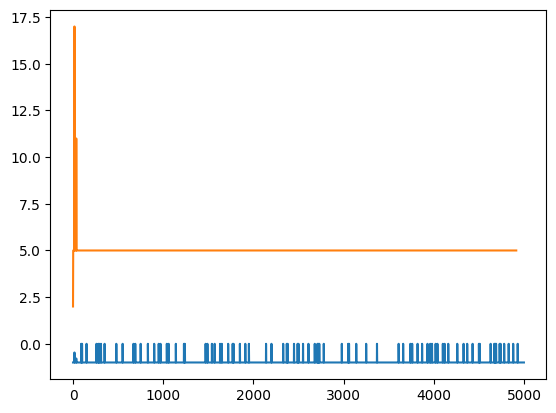

In [ ]:
plt.plot(Cum_reward_arr)
plt.plot(no_of_timestep)

In [ ]:
x = torch.tensor([1,2,3,4,5,6,7,8,9])
x = x.view(-1, 3)
torch.gather(x, 1, torch.tensor([0,1,0]))

RuntimeError: Index tensor must have the same number of dimensions as input tensor

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [ ]:
x = torch.tensor([1,2,3,4,5,6,7,8,9])
x = x.view(-1, 3)
idx = torch.tensor([0,1,0])
idx = idx.repeat(x.size()[0], 1)  # repeat idx for each row of x
torch.gather(x, 1, idx)

tensor([[1, 2, 1],
        [4, 5, 4],
        [7, 8, 7]])

In [ ]:
x = torch.tensor( [ [ 0.2308,  0.1351,  0.1310],
                    [ 0.3405, -0.1738,  0.0268],
                    [-0.3404, -0.1835, -0.0311],
                    [ 0.1829,  0.1309,  0.0402],
                    [ 0.0356, -0.1477,  0.0833],
                    [ 0.0149, -0.1418, -0.1558],
                    [ 0.1514, -0.0096, -0.0639],
                    [-0.0182,  0.2285, -0.2660],
                    [-0.0203, -0.1473,  0.1908],
                    [ 0.2329, -0.0408, -0.0517] ])

idx = torch.tensor([[0],[1],[0],[0],[1],[0],[0],[1],[0],[1] ])
torch.gather(x, 1, idx).squeeze()

tensor([ 0.2308, -0.1738, -0.3404,  0.1829, -0.1477,  0.0149,  0.1514,  0.2285,
        -0.0203, -0.0408])

In [ ]:
nao.getAnglesPosition(legJoints)

[0.12732641861268773,
 -0.09232883557470185,
 0.08689823896103306,
 0.12725468390537428,
 -0.09232541573536869,
 0.08695699523751238]

In [ ]:
nao.getPosition()

(1.0646830579174167, 0.09673968989419303, 1.3109619171424003)

In [ ]:
t = [0.12832641861268773,
 -0.09232883557470185,
 0.08689823896103306,
 0.12725468390537428,
 -0.09232541573536869,
 0.18695699523751238]

nao.setAngles(legJoints, t, 0.5)

In [ ]:
env_reset()

In [ ]:
imu = nao.getImu()
nao.subscribeImu(frequency=100)
x, y = nao.getImuValues()

In [ ]:
y

[-0.0025193699334536816, 0.022667746960935185, -0.003590342319071725]

(-0.0014550485393115026, -0.0014375405333474796, -0.0006399613056351145)

In [ ]:
imu = nao.getImu()
nao.subscribeImu(frequency=100)
nao.P_STAND_INIT


AttributeError: 'SimulationManager' object has no attribute 'getBasePositionAndOrientation'

In [ ]:
import pybullet as p

In [ ]:
env_reset()

In [ ]:
fallen = False
import threading

def nao_fall_detect():
    nao.subscribeImu(frequency=100)
    global fallen
    while True:
        acc = nao.getImuAccelerometerValues()
        gyr = nao.getImuGyroscopeValues()
        gyr = list(gyr)
        acc = list(acc)
        if gyr[1] < -4 or acc[2]<-6:
            print("-------")
            fallen = True
        time.sleep(0.1)
        
t1 = threading.Thread(target= nao_fall_detect)
t1.start()

In [ ]:
fallen

False

In [ ]:
t = [0.12832641861268773,
 -0.09232883557470185,
 0.08689823896103306,
 0.12725468390537428,
 -0.09232541573536869,
 0.18695699523751238]

nao.setAngles(legJoints, t, 0.5)
print(fallen)

False


-------
-------


In [ ]:
fallen

True

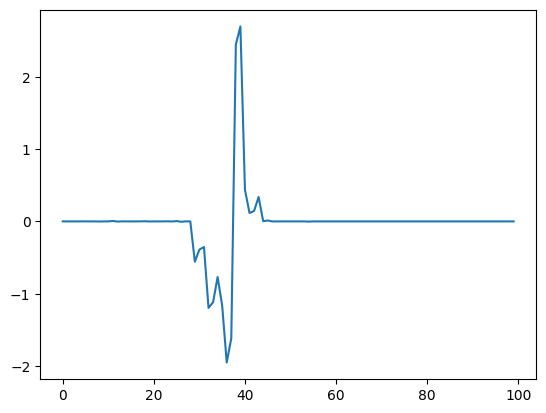

In [ ]:
plt.plot(a)


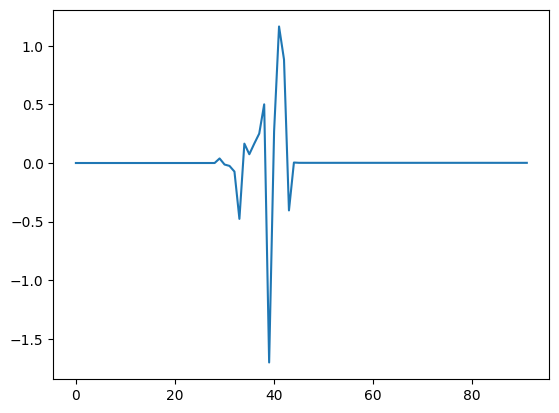

In [ ]:
plt.plot(a)

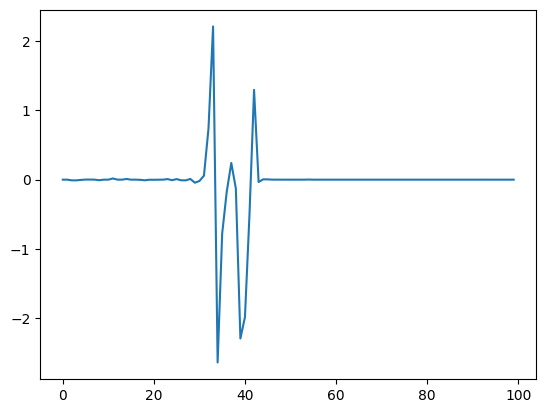

In [ ]:
plt.plot(b)

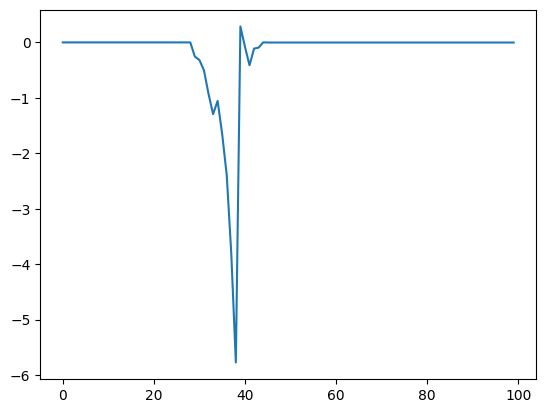

In [ ]:
plt.plot(b)

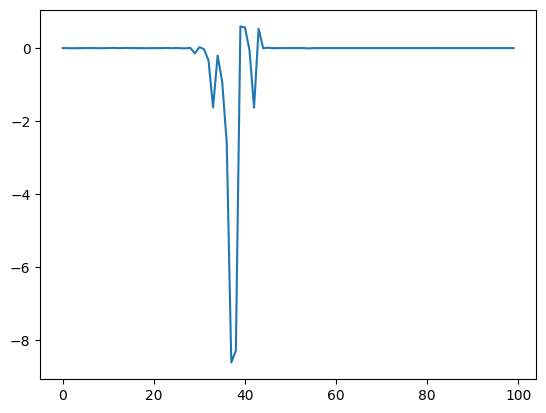

In [ ]:
plt.plot(c)

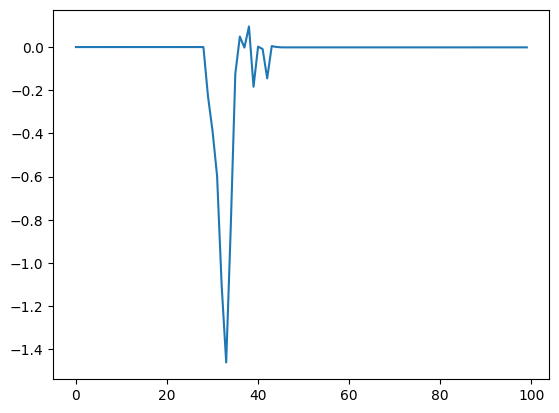

In [ ]:
plt.plot(c)

In [ ]:
import threading

def nao_fall_detect():
    global acc_vals , gyr_vals, check_fall
    acc_vals = []
    gyr_vals = []
    while check_fall:
        itr += 1
        acc = nao.getImuAccelerometerValues()
        gyr = nao.getImuGyroscopeValues()
        acc_vals.append(acc)
        gyr_vals.append(gyr)
        time.sleep(0.1)


((0.010813103059841043, -0.3265117032109139, 0.05991866165981999),
 (0.011534529263936165,
  -0.7089003677591622,
  0.00990892805360312,
  0.7051446917976568))

In [ ]:
model(torch.randn(1, 10))

tensor([[ 1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.]],
       grad_fn=<SignBackward0>)

## THis is directly learning policy not value

In [ ]:
import torch
import torch.nn as nn

class AV(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) 
        x = self.custom_activation(x)
        return x

    def custom_activation(self, x):
        x = torch.where(x < -0.33, torch.tensor(-1.0), x)
        x = torch.where((x >= -0.33) & (x <= 0.33), torch.tensor(0.0), x)
        x = torch.where(x > 0.33, torch.tensor(1.0), x)
        return x

model = MyModel()

In [ ]:
model(torch.randn(1, 10))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<WhereBackward0>)